# Advanced Statistic -- Exercize Sheet 8

Valente Alessandro 1234429


## Ex1

Students from the Bachelor degree in Physics performed an experiment to study the Zeeman effect.
The apparatus contains a Ne source lamp whose position can be changed. During the setting up
of the apparatus, the source position has to be adjusted in order to maximize the intensity of the
detected light signal.

 The following table gives the position of the source (in mm) and the corresponding height of the
peak (arbitrary units) for the wavelength under study:

$$\begin{array}{c|cccccccccc}
\hline x_{i} & 2.44 & 3.49 & 3.78 & 3.31 & 3.18 & 3.15 & 3.1 & 3.0 & 3.6 & 3.4 \\
y_{i} & 129 & 464 & 189 & 562 & 589 & 598 & 606 & 562 & 360 & 494 \\
\hline
\end{array}$$

Assume a quadratic dependence of the peak height, yi as a function of the source position $x_i$
$$f(x)=c_{0}+c_{1} x+c_{2} x^{2}$$

All the measured values are affected by a Gaussian noise with zero mean, such that
$$ yi = f(xi) + \epsilon $$
where $\epsilon$ follows a normal distribution with mean µ = 0 and unknown standard deviation, σ

**A)** Build a Markov Chain Monte Carlo to estimate the best parameters of the quadratic dependence
of the data and the noise that affects the measured data.

The first thing i do is defining the ***metrop*** function which computes the MCMC for a given function, in particular it recives
- func: the function posterior, in particular i chose to use functions which returns only the logarithm of the posterior and not the prior and likelihood separately
- th_start: the starting values for the parameter
- n_burn: the number of samples to be burned
- n_samp: the number of samples to compute after the burning
- sigma: the standard deviation (or matrix of deviations) for the choice of the proposal points
- ...: the optional parameters needed for the posterior function to work

In [1]:
library(mvtnorm) 
metrop <- function(func, th_start, n_burn, n_samp, sigma, ...) {
  #initializations
    n_par   <- length(th_start);   th_iter <- th_start;   f_iter  <- func(th_start, ...) 
    f_samp <- matrix(data=NA, nrow=n_samp, ncol=1+n_par) 
    n_acc  <- 0;    r_acc <- 0
 
    for(n in 1:(n_burn+n_samp)) {
        #using a simmetric proposal i have no hasting factor 
        #th_prop <- th_start
        #th_prop <- ifelse (is.null(dim(sigma)),  
        #                   rnorm(1, th_iter, sqrt(sigma)), 
        #                   rmvnorm(1, th_iter, sigma=sigma))
        
        if(is.null(dim(sigma))) sigma <- as.matrix(sigma)
        th_prop <- rmvnorm(1, th_iter, sigma=sigma)
        #print(th_iter)
        #print(sigma)
        #print(th_prop)
        #print(rmvnorm(1, th_iter, sigma=sigma))
        #print(paste("thp",th_prop))
        f_prop  <- func(th_prop, ...)  #proposed value
        logMR <- f_prop - f_iter
        if(logMR>=0 || logMR>log10(runif(1, min=0, max=1))) {
            th_iter <- th_prop ; f_iter <- f_prop
            n_acc <- n_acc + 1; r_acc <- n_acc/n
        }
        if(n>n_burn) {
            f_samp[n-n_burn,1] <- f_iter
            f_samp[n-n_burn,2:(1+n_par)] <- th_iter
        }   
    }
    return(f_samp)
}

 Now i defined the model to infer the posterior PDF over its parameters, given the model:
 $$ y_i=f(x_i) + \epsilon \qquad f(x)=a+bx+cx^2 $$
 i choose to use instead of the original parameters $\alpha = \tan^{-1}b$ and $\log_{10} \epsilon$ with the following priors:

- a:         Norm(mean=m, sd=s)
- $\alpha$:       Uniform (0 to 2pi)
- c:         N(mean=m, sd=s)
- log10(ysig): Uniform

In [2]:
quad_like <- function(theta, obs) {
  # convert alpha to b and log10(ysig) to ysig
  theta[2] <- tan(theta[2])
  theta[4] <- 10^theta[4]
  modPred <- drop( theta[1:3] %*% t(cbind(1,obs$x,obs$x^2)) )
    #compute the likelihood
  logLike <- (1/log(10))*sum( dnorm(modPred - obs$y, mean=0, sd=theta[4], log=TRUE) )
  return(logLike)
}

quad_prior <- function(theta) {
  b0Prior      <- dnorm(theta[1], mean=0, sd=10)
  alphaPrior   <- 1
  b2Prior      <- dnorm(theta[3], mean=0, sd=5)
  logysigPrior <- 1 
    #compute total model prior
  logPrior <- sum( log10(b0Prior), log10(alphaPrior), log10(b2Prior), log10(logysigPrior) )
  return(logPrior)
}

quad_post <- function(theta, obs) {
    return (quad_like(theta,obs)+quad_prior(theta)) #i sum since the functions return the log10
}

The model is now defined but before running the metrop function i did one last thing: since the given data have really high value i applied a linear transformation to them in order to allow the model to converge easily, in particulat i defined 2 quantities: $\delta$ which is a traslation along the x axis and $\varsigma$ which is a scale parameter to transform the y-axis.

In this way the transformation can be see as a linear map which transform the cooridinates:
$$
\mathcal{G}: 
 \begin{pmatrix} x \\ y \end{pmatrix}
 \longrightarrow 
 \begin{pmatrix} x' \\ y' \end{pmatrix} =
 \begin{pmatrix} x-\delta \\ y/\varsigma \end{pmatrix}
$$

In this new system of coordinates the model is the same since the map is linear, in particular i will name with ' the parameters fitted in the new system.
We can now run the chain.

In [3]:
#given data
X <- c( 2.44, 3.49 ,3.78, 3.31, 3.18, 3.15 ,3.1 ,3.0, 3.6, 3.4)
Y <- c(129, 464 ,189 ,562, 589, 598, 606, 562 ,360, 494)

#trasformation params
delta <- 3; scale <- 100 #more on this later
x <- X-delta; y <- Y/scale #transform
data <- data.frame(cbind(x,y)) #make the data set for the metropolis

#params for the metrop
sampleCov <- diag(c(0.1, 0.01, 0.01, 0.01)^2)
thetaInit <- c(-2, 0, -10, log10(1))
set.seed(250)
#run the chain
allSamp <- metrop(func= quad_post ,th_start = thetaInit ,n_burn=2e4,
n_samp = 1e5 ,sigma = sampleCov, obs=data)

After running the chain to reduce the correlation in the parameters estimation we can do a thinning of the samples:

After this we can now plot the parameters and their most probable value which is estimated from the maximum of the global posterior distribution function; the plotted parameters refers to the trasformed data.

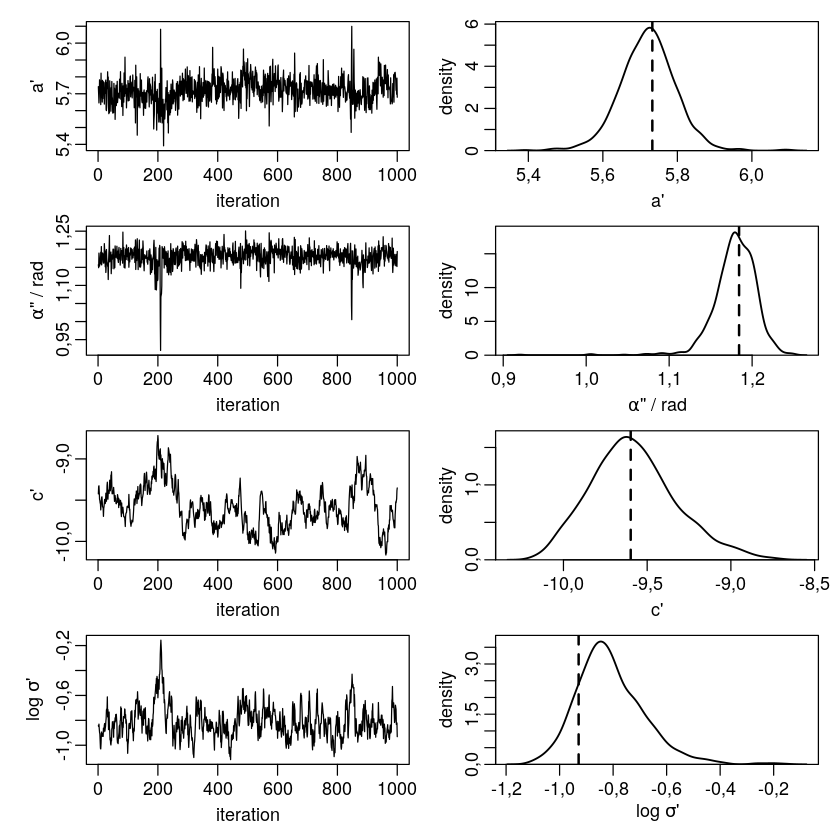

In [4]:
#to reduce correlation a thinning of the chain is done
thinSel  <- seq(from=1, to=nrow(allSamp), by=100) # thin by factor 100
postSamp <- allSamp[thinSel,]

par(mfrow=c(4,2), mar=c(3.0,3.5,0.5,0.5), oma=0.5*c(1,1,1,1), mgp=c(1.8,0.6,0), cex=0.9)
parnames <- c(expression("a'"), expression(paste(alpha, "'' / rad")), expression("c'"), 
              expression(paste(log, " ", sigma, "'")))

params <- postSamp[which.max(postSamp[,1]), 2:5] #maximum of ther posterior
for(j in 2:5) { # columns of postSamp
  plot(1:nrow(postSamp), postSamp[,j], type="l", xlab="iteration", ylab=parnames[j-1])
  postDen <- density(postSamp[,j], n=2^10)
  plot(postDen$x, postDen$y, type="l", lwd=1.5, yaxs="i", ylim=1.05*c(0,max(postDen$y)),
       xlab=parnames[j-1], ylab="density")
    abline(v=params[j-1], lty="dashed", col="black", lwd=2)
}

To plot the model we have to revert the fit parameters to their original structure in the model and only then compute the maximum. After this is done we have the coefficient of the quadratic function and the deviation of the noise.

These parameters refers still to the transormed data, to get the original parameters we have to invert the map applied to the model and set then match the coefficients, this is possible since the map is linear, let's at first examine the relation along the y axis:
$$
y_i'=f'(x_i') +\epsilon ' = \frac{y_i}{\varsigma} =\frac{1}{\varsigma}(f(x_i) +\epsilon )
$$

From this we have obtain two realtions:
$$
\epsilon =\varsigma \cdot \epsilon' \\
f(x_i) = \varsigma \cdot f'(x_i')
$$

In this way one we already obtained the transformation of one parameter, the others can be obtained from the second relation by explicitly writing the function, applying the map definition for $x'$ and matching the coefficients:
$$
\begin{aligned}
a+bx+cx^2 & = \varsigma(\, a'+b'x'+c'x'^2\,) \\
          & = \varsigma(\,a' +b'(x-\delta)+c'(x-\delta)^2\,) \\
          & = \varsigma(\, a' +b'x-\delta b' +c'x^2 +c'\delta^2 -2c'\delta x \,)
\end{aligned}
\implies
\begin{cases}
a=\varsigma (a'-\delta b' +c'\delta^2 ) \\
b=\varsigma (b'- 2c'\delta )\\
c=\varsigma c'
\end{cases}
$$




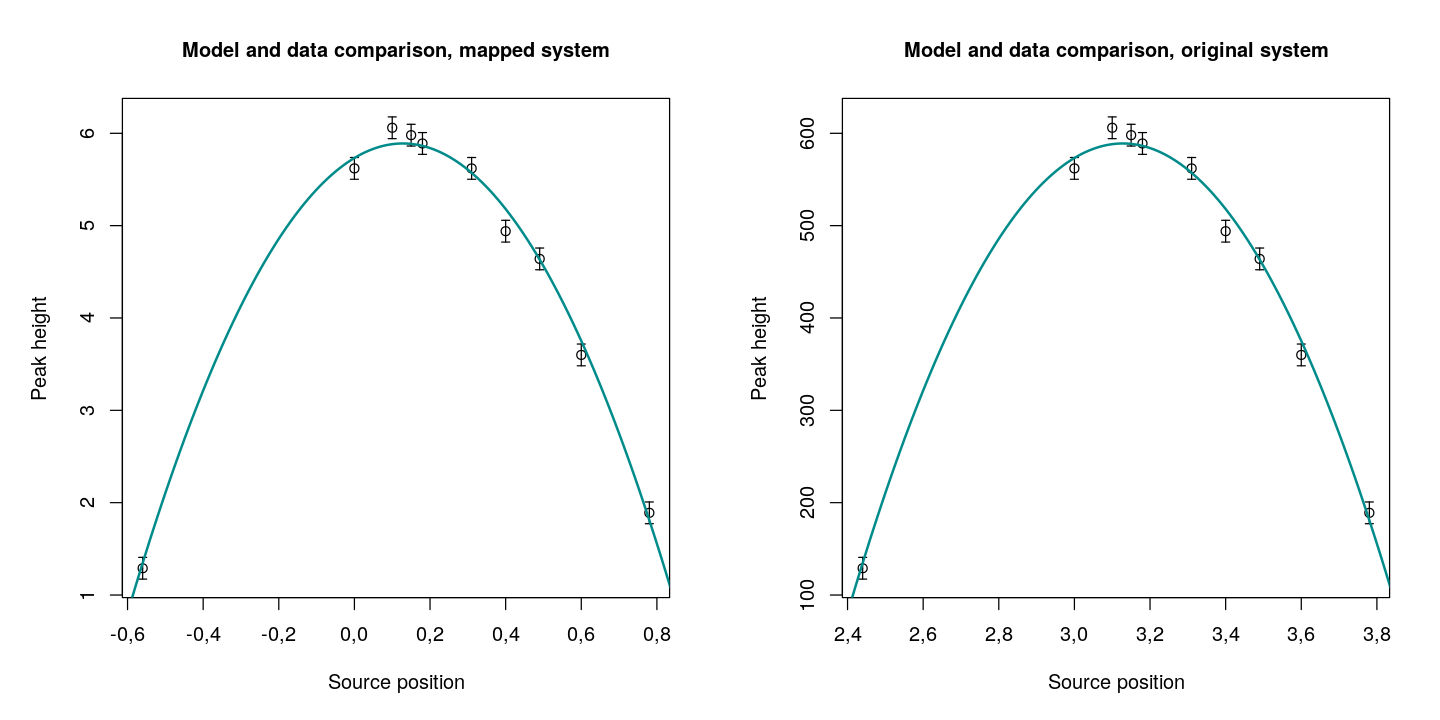

In [5]:
post_trsf <- postSamp #copy parameters
post_trsf[,3] <- tan(post_trsf[,3])  #trasform them back to orignial
post_trsf[,5] <- 10^post_trsf[,5]
params_orig <- post_trsf[which.max(post_trsf[,1]), 2:5] #maximum of ther posterior for starting params
par_cov <- cov (postSamp[,2:5]) #compute covariance and correlation
par_cov_orig <- cov(post_trsf[,2:5])

#get ampped params and from them computed orignal model params
a1 <- params_orig[1]; b1 <- params_orig[2]; c1 <- params_orig[3]; sig1 <- params_orig[4]
a <- scale*(a1-delta*b1+c1*delta^2); b <- scale*(b1-2*c1*delta); c <- scale*c1; sig <- sig1*100

#plot funciton
plot_quad_trsf <- function(x){
    return(a1+b1*x+c1*x^2)
}
plot_quad <- function(x){
    return(a+b*x+c*x^2)
}


par(cex.lab=1, cex.axis=1, cex.main=1, mar=c(5, 5, 4, 2) + 0.1)
options(repr.plot.width=12,repr.plot.height=6)
area <- matrix (c(1,2), nrow=1, ncol=2, byrow=TRUE)
layout(area)

xs <- seq(-.6,0.9,0.01)
Xs <- seq(2.4, 3.9, 0.01)
plotrix::plotCI(x,y, uiw=sig1, xlab="Source position", ylab="Peak height", main="Model and data comparison, mapped system")
lines(xs, plot_quad_trsf(xs), lwd=2, col='dark cyan')
plotrix::plotCI(X, Y, uiw=sig, xlab="Source position", ylab="Peak height", main="Model and data comparison, original system")
lines(Xs, plot_quad(Xs), lwd=2, col='dark cyan')

As we can see in both cases the model has a very good agreemnt with the data provided.

As can be seen from our data, the students forgot to take measurements in the region $x \in (2.44, 3.0)$

**B)** run a Markov Chain Monte Carlo to predict peak height measurements at $x_1 = 2.8 mm$ and
$x_2 = 2.6 mm$

To estimate the point value we can define a new function using the previous obtained parameters and use it to run the chain, the values can then be computed using the indirect method, namely by factorizing the joint distribution.

In [6]:
#this returns the log of the quadratic model, since in the first itereation the x value
#can go to far values we have to add a control, in this way this function is defined positive
metrop_quad <- function ( x) { 
   ifelse(plot_quad_trsf(x)>0, log10(plot_quad_trsf(x)), 0.00001)
}
x_start <- 0
sigm <- 0.1
n_samp <- 3e5

set.seed(20190513)
#run the chain and thin it
chain <- metrop(func= metrop_quad ,th_start = x_start ,n_burn=2e4,
n_samp = n_samp ,sigma = sigm^2)
thinSel  <- seq(from=1, to=nrow(allSamp), by=100) # thin by factor 100
postSamp <- allSamp[thinSel,]


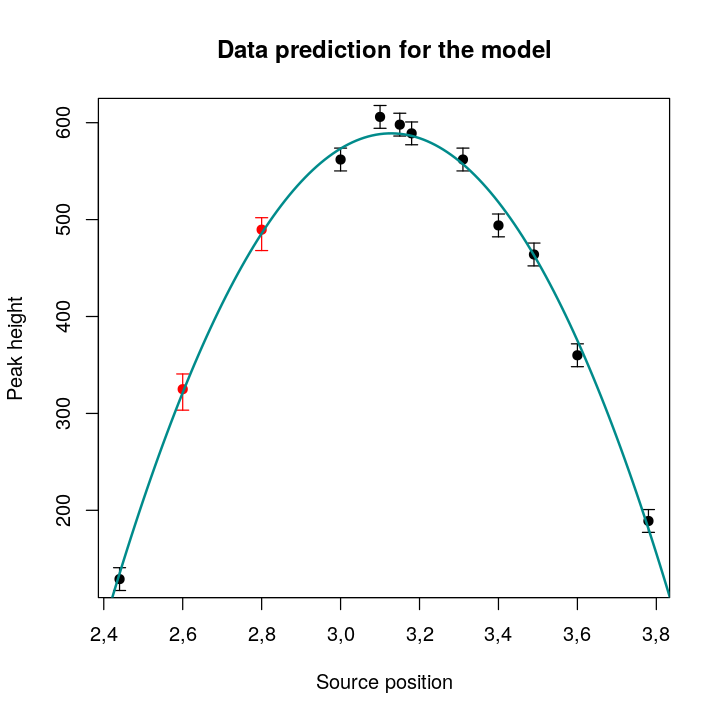

In [7]:
#new values
xnew_1 <- 2.8-delta
xnew_2 <- 2.6-delta
#fucntion tu predict value in the indirect methoid
predict <- function(xn){
    modPred <- cbind(postSamp[,2], tan(postSamp[,3]),postSamp[,4]) %*% t(cbind (1,xn, xn^2 ))
    likeSamp <- rnorm(n= length ( modPred ), mean=modPred , sd=10^postSamp [,5])
    likeDen <- density (likeSamp , n=2^10)
    y <- c( likeDen $x[ which.max( likeDen $y)], quantile (likeSamp ,
                        probs =c( pnorm (-1), pnorm (+1)), names= FALSE ))
    return(y)
}

#trasform the predictions
x_new <- c(xnew_1, xnew_2)
X_new <- x_new+delta
y_new <- cbind(predict(xnew_1), predict(xnew_2))
Y_new <- y_new*100

options(repr.plot.width=6,repr.plot.height=6)

plot(c(X, X_new), c(Y, Y_new[1,]),
    pch=19, xlab="Source position", ylab="Peak height",
    main="Data prediction for the model", col=c(rep('black', length(X)),rep('red', length(X_new)))
)
#plotrix is tricky with many set of points so its easier to draw arrows but with very special arrow making them errorbars
arrows(c(X, X_new), c(Y-sig, Y_new[2,]),
       c(X, X_new), c(Y+sig, Y_new[3,]), length=0.05, angle=90, code=3,
       col=c(rep('black', length(X)),rep('red', length(X_new))))
lines(Xs,plot_quad(Xs), lwd=2, col="dark cyan")




## Ex2

The number of British coal mine disasters has been recorded from 1851 to 1962. By looking at the data it seems that the number of incidents decreased towards the end of the sampling period. We model the data as follows:
- before some year, we call $\tau$ , the data follow a Poisson distribution, where the logarithm of the mean value, $\log \mu t = b_0$, while for later years, we can model it as $\log \mu t = b_0 + b_1$
- the dependence can be modeled as follows $y_t \sim Pois(\mu t)$, where $\log \mu t = b_0 + b_1 Step(t − \tau )$

Implement the model in jags, trying to infer the parameters $b_0, b_1$ and $\tau$
- the step function is implemented, in BUGS, as step(x) and return 1 if x ≥ 0 and 0 otherwise
- assign a uniform prior to $b_0, b_1$ and a uniform prior in the interval $(1, N)$, where $N = 112$ is the number of years our data span on
- finally, here is our data:

data $<-$ NULL 

data $\$ \mathrm{D}<-\mathrm{c}(4,5,4,1,0,4,3,4,0,6,$
$3,3,4,0,2,6,3,3,5,4,5,3,1,4,4,1,5,5,3,4,2,5,2,2,3,4,2,1,3,2,$
$1,1,1,1,1,3,0,0,1,0,1,1,0,0,3,1,0,3,2,2,$
0,1,1,1,0,1,0,1,0,0,0,2,1,0,0,0,1,1,0,2
2,3,1,1,2,1,1,1,1,2,4,2,0,0,0,1,4,0,0,0
1,0,0,0,0,0,1,0,0,1,0,0)

data $\$ N<-112$

- before running jags, assign an initial value to the parameters as follows: $b_0 = 0, b1 = 0$ and $\tau = 50$
- explore the features of the chains and try to understand the effects of the burn-in, and thinning
- plot the posterior distributions of the parameters and extract their mean values, and 95% credibility interval

In [8]:
library(rjags)

Warning message:
“package ‘rjags’ was built under R version 3.6.3”
Loading required package: coda

Warning message:
“package ‘coda’ was built under R version 3.6.3”
Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



In [9]:
data  <- NULL
data$D<- c(4,5,4,1,0,4,3,4,0,6,   
           3,3,4,0,2,6,3,3,5,4,
           5,3,1,4,4,1,5,5,3,4,
           2,5,2,2,3,4,2,1,3,2,   
           1,1,1,1,1,3,0,0,1,0,
           1,1,0,0,3,1,0,3,2,2,  
           0,1,1,1,0,1,0,1,0,0,
           0,2,1,0,0,0,1,1,0,2,
           2,3,1,1,2,1,1,1,1,2,
           4,2,0,0,0,1,4,0,0,0,
           1,0,0,0,0,0,1,0,0,1,0,0)
data$N <-112
#define vector of starting values
start_val <- NULL
start_val$tau <- 50
start_val$b0  <-  0
start_val$b1  <-  0

It's now possible to define the model of the distribution, the model is defined using the BUGS languege as a string and then passed to the function textConnection, making is possible to be used in JAGS; this operation allows us to define the model inside the notebook without relying on external files.

In [10]:
modelString <- "
model {
for (year in 1:N) {
D[year] ~ dpois(mu[year])
log(mu[year]) <- b0 + step(year - tau) * b1
}
b0 ~ dunif(-5,5)
b1 ~ dunif(-5,5)
tau ~ dunif(1,N)
}
"
model<-textConnection(modelString)

Now that the data and the model alongside with the starting value of the parameters has been defined we can run the MCMC in order to obtain a first inference of the parameters. In this run i used a factor 10 thinning on the generated samples and a 1000 samples burn-in. In particular the 1000 sample burn-in is performed before the start of the chain by the jags package in the definition of the model.  The choice of burn-in and thinning is then depth below.


In [11]:
model<-textConnection(modelString)
jm <- jags.model(model, data, start_val, n.adapt = 1000) 
# update(jm, 1000) # jags.model does 1000 sample burn in, alternatively i can use this
chain <- coda.samples(jm, c("tau", "b0", "b1"), n.iter=1000, thin=10) #run the chain
print(summary(chain))#print results

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 3
   Total graph size: 789

Initializing model


Iterations = 1010:2000
Thinning interval = 10 
Number of chains = 1 
Sample size per chain = 100 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean     SD Naive SE Time-series SE
b0   1,145 0,1009  0,01009        0,01009
b1  -1,269 0,1635  0,01635        0,01635
tau 39,649 2,3836  0,23836        0,19111

2. Quantiles for each variable:

       2,5%    25%    50%    75%  97,5%
b0   0,9718  1,074  1,154  1,208  1,341
b1  -1,6086 -1,372 -1,234 -1,154 -1,029
tau 36,1353 37,626 39,657 40,810 46,192



**Burn-in**

In order to see the effect of the burn in we can plot the value of the parameters and their total PDF during the chain without burning the first samples.
To better see the effect of the burn-in it is usefull to start the chain in a low probability region, in order to do this i used starting values very different from the ones obtained in the run before. 

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 3
   Total graph size: 789

Initializing model

NOTE: Stopping adaptation




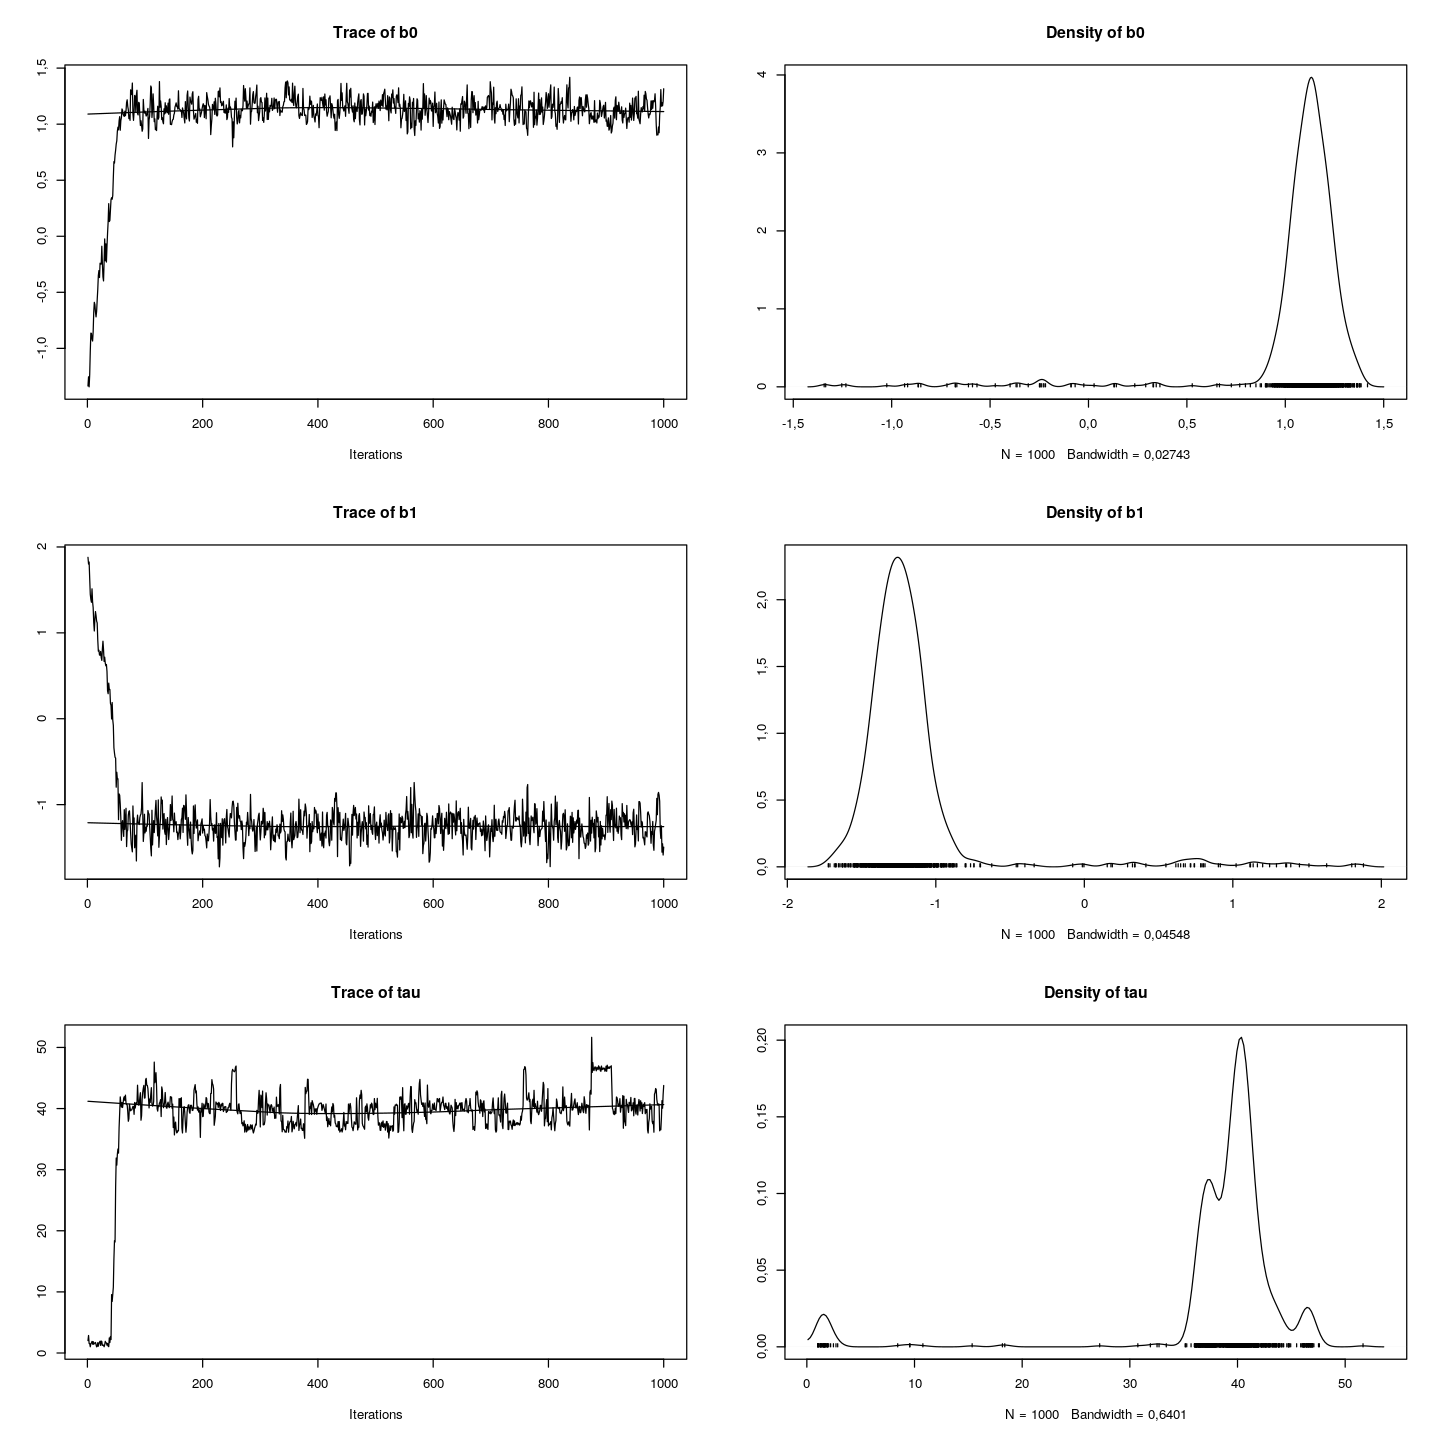

In [12]:
start_val2 <- NULL
start_val2$tau <- 3
start_val2$b0  <-  -1
start_val2$b1  <-  2
options(repr.plot.width=12,repr.plot.height=12)


model<-textConnection(modelString)
jm <- jags.model(model, data, start_val2, n.adapt = 0) #impose not to burn any sample
chain <- coda.samples(jm, c("tau", "b0", "b1"), n.iter=1000, thin = 1) #run the chian
plot(chain)


As we can see when the starting values are very far from the high probability density region the first iteration of the chain must discarded to perform a good estimation of the parameters, which is effectively done with the burn-in as we can see from the plot below.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 3
   Total graph size: 789

Initializing model



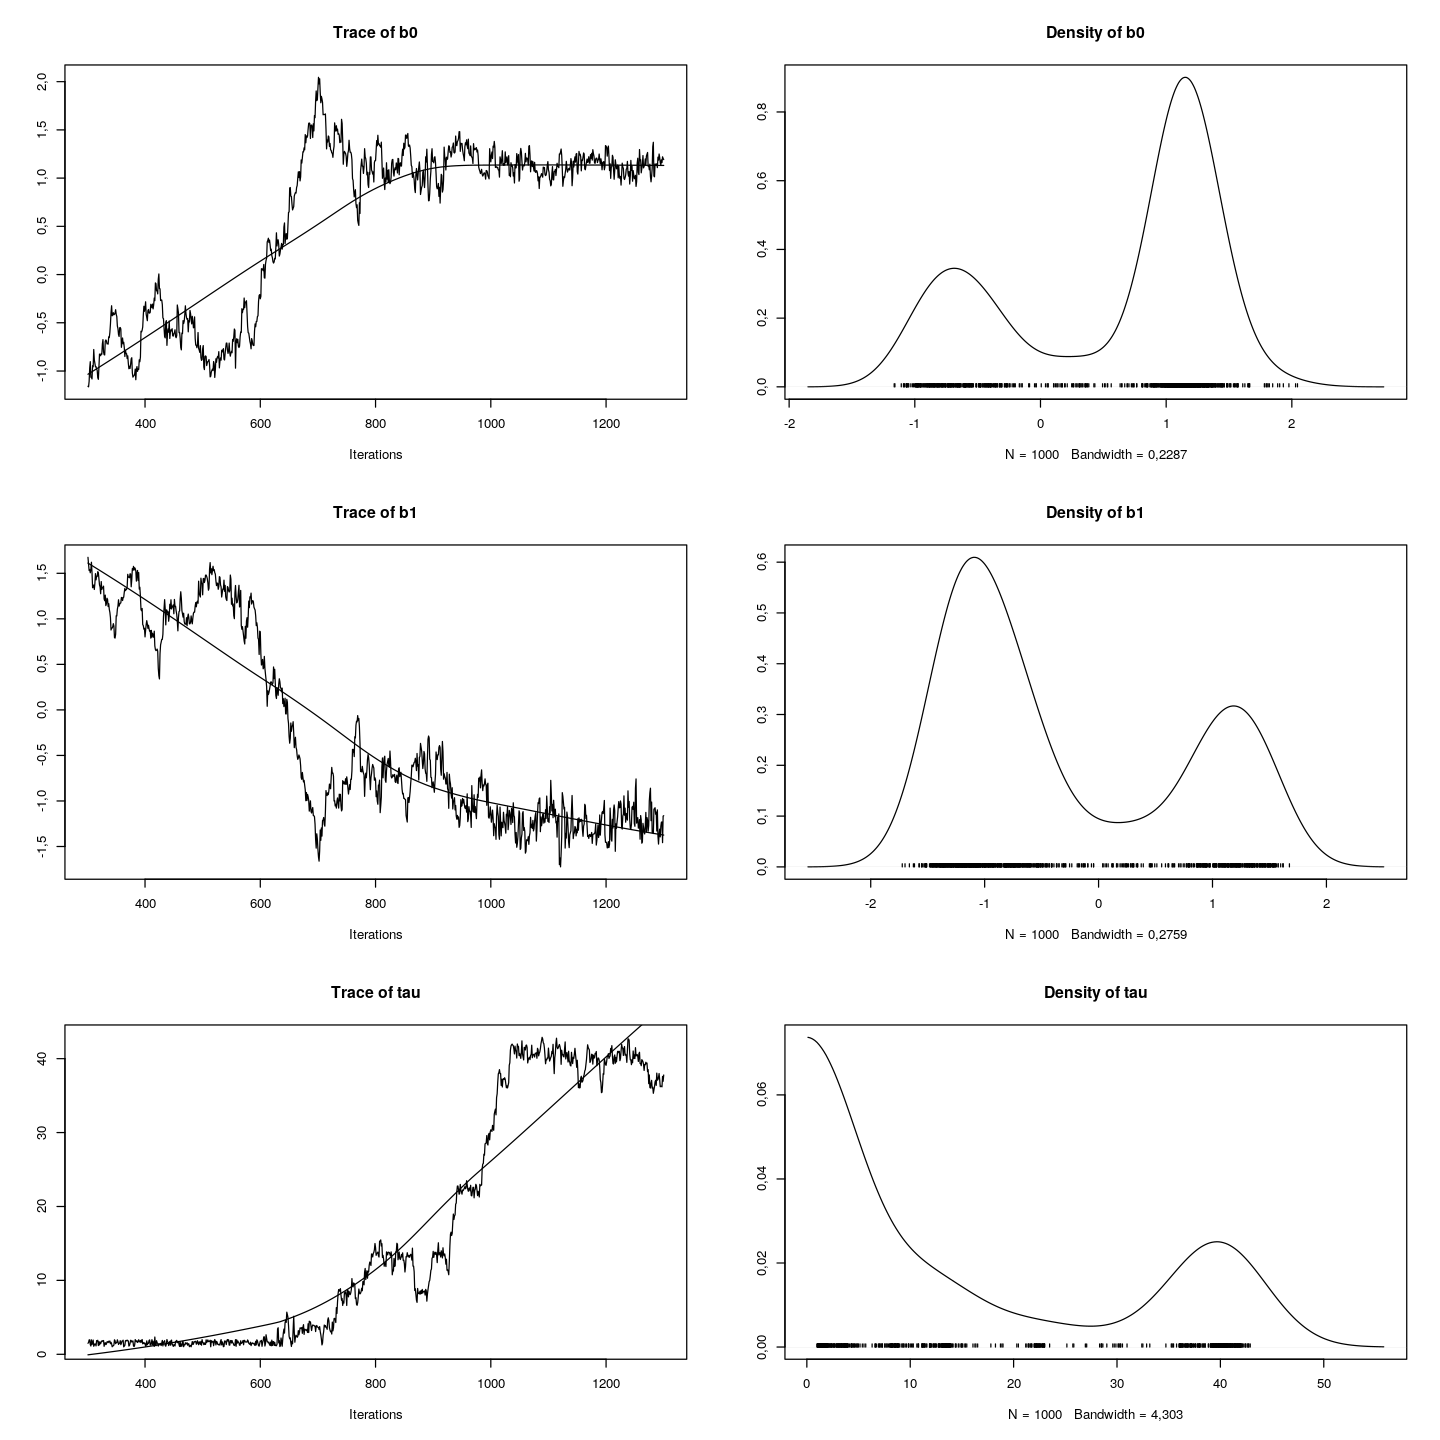

In [13]:
model<-textConnection(modelString)
jm <- jags.model(model, data, start_val2, n.adapt = 300) #burn first 300 (low density region)
chain <- coda.samples(jm, c("tau", "b0", "b1"), n.iter=1000, thin = 1) #run the chian
plot(chain)

**Thinning**

The thinning effect can be observed by looking at the autocorrelation plot of the parameters along the chain.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 3
   Total graph size: 789

Initializing model



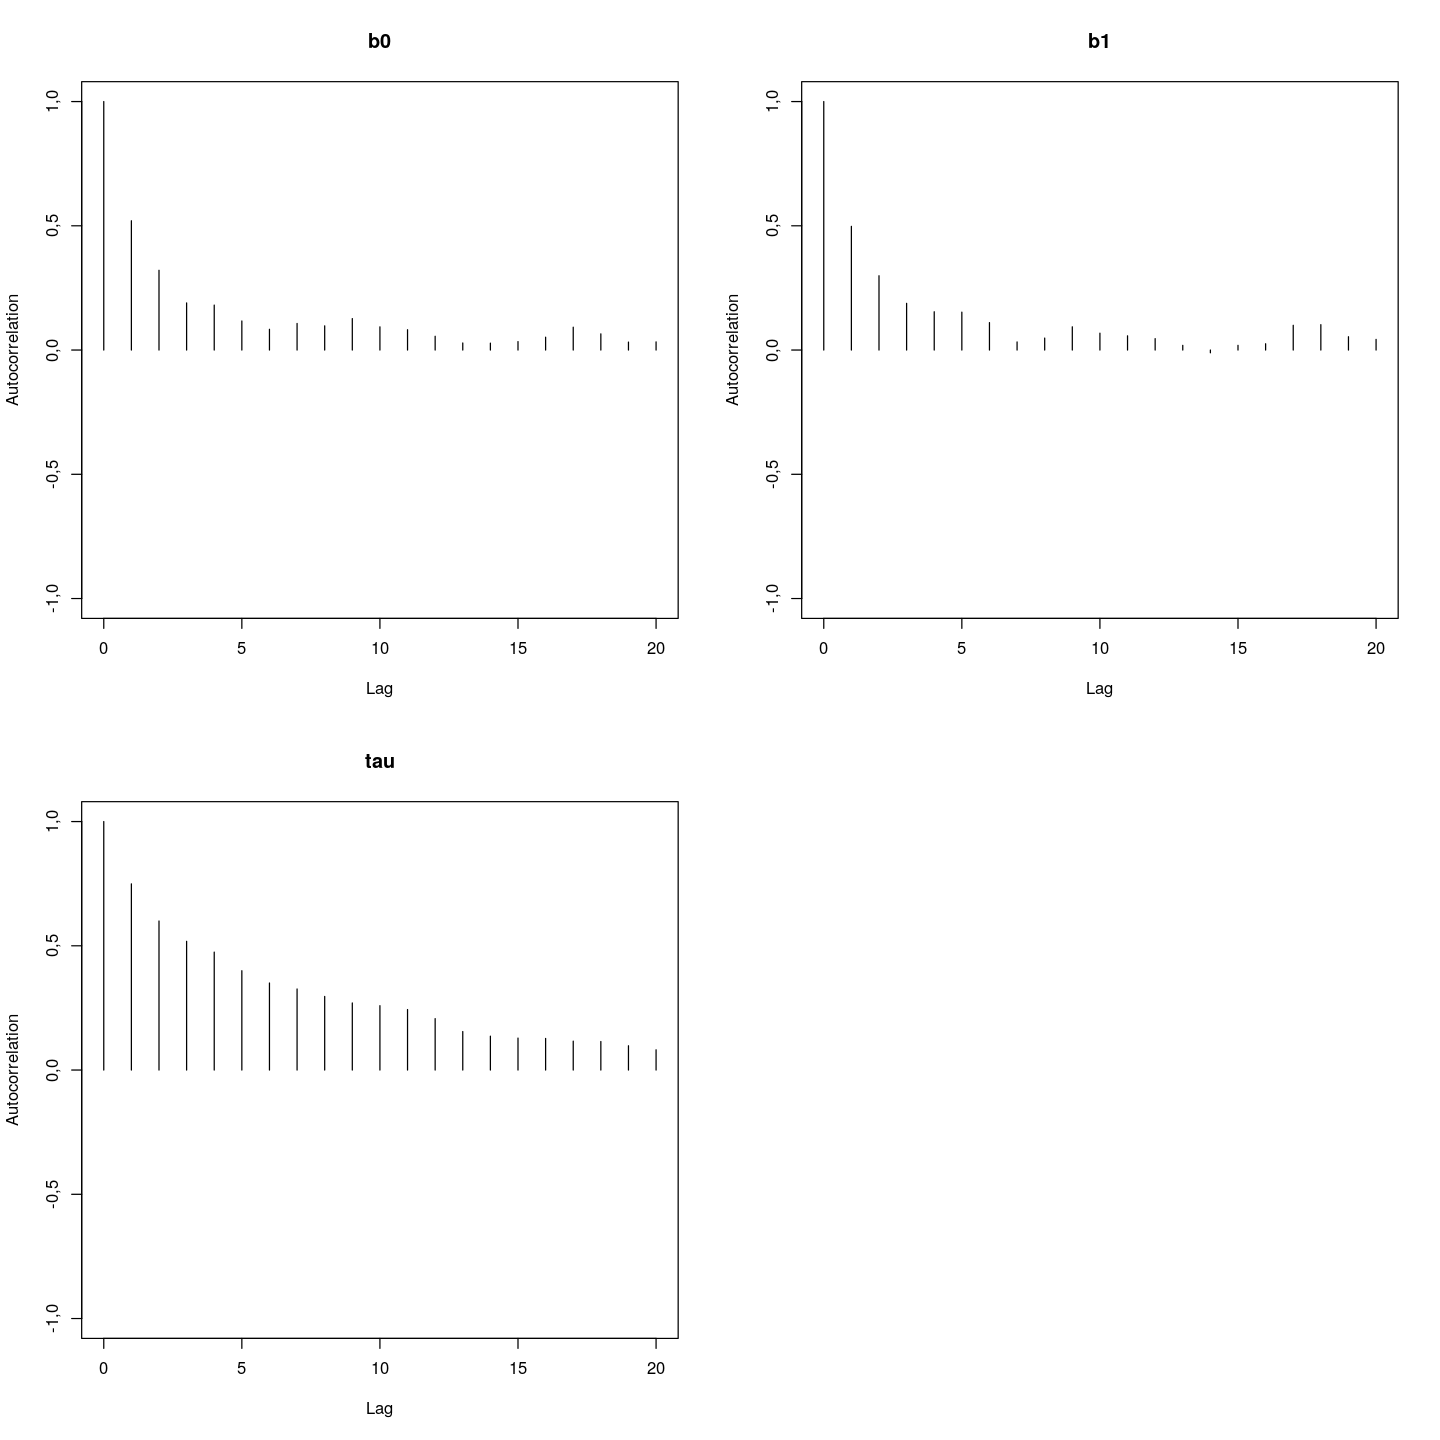

In [14]:
model<-textConnection(modelString)
jm <- jags.model(model, data, start_val, n.adapt = 300)
chain <- coda.samples(jm, c("tau", "b0", "b1"), n.iter=1000, thin = 1)
autocorr.plot(as.mcmc(chain), lag.max = 20)

This plot shows that after 10 iterations (lag) the value of the autocorrelation between samples is almost zero for all the parameters this means that applying a thinning factor 10 to the chain allows us to consider the samples as if they were indipendently sampled. This process however is really inefficient since it discards the 90% fo the chain, in fact in case of very long chains also a thinning factor $3\sim 5$ can be considered enough since the autocorrelation is already low at for those lag values.  

The effect of the thinning is then visible from the plot below which clearly shows that the autocorrelation between samples is really low even with only 5 as thinning factor.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 3
   Total graph size: 789

Initializing model



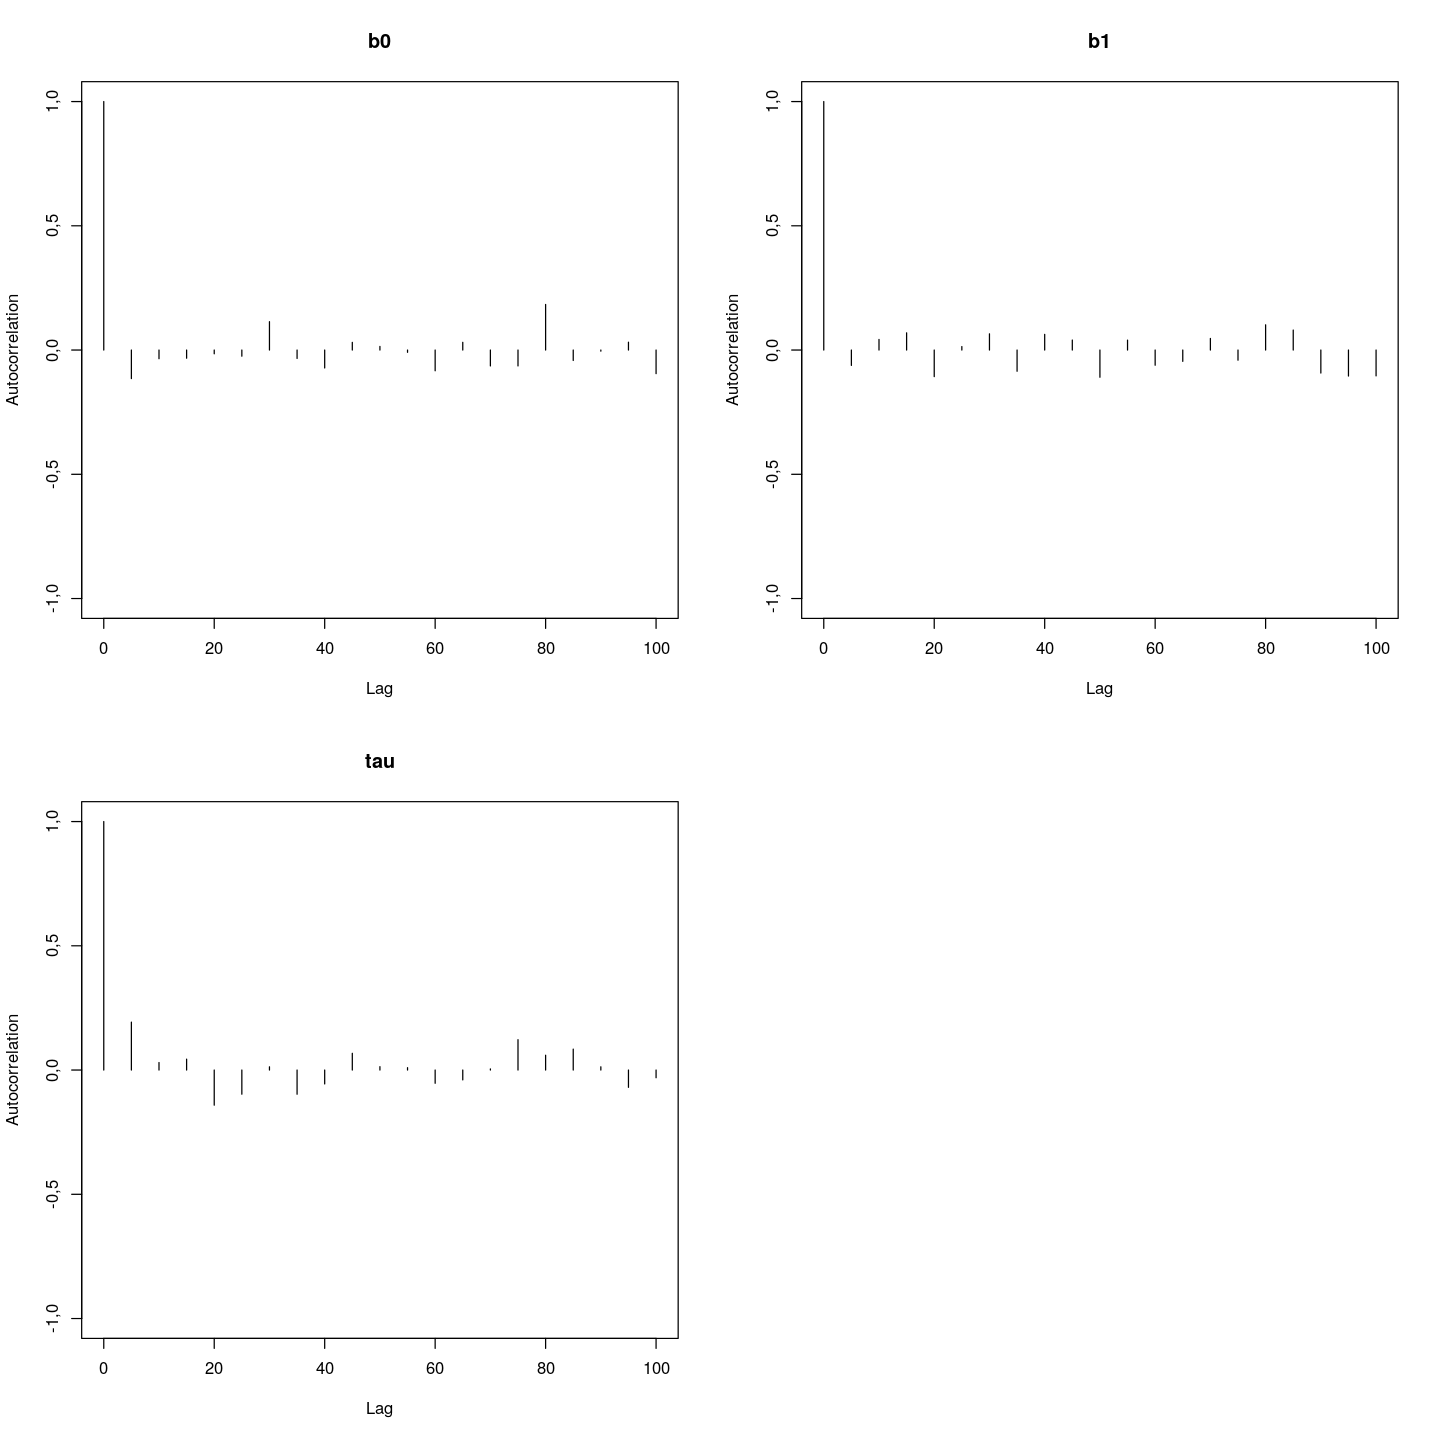

In [15]:
options(repr.plot.width=12,repr.plot.height=12)
model<-textConnection(modelString)
jm <- jags.model(model, data, start_val, n.adapt = 300)
chain <- coda.samples(jm, c("tau", "b0", "b1"), n.iter=1000, thin = 5)
autocorr.plot(as.mcmc(chain), lag.max = 20)

**Posterior Distributions**

Using the burn-in and thinning factor from the analysis before is now possible to run the MCMC in order to infere the parameters. In particular the plot function of the model show us the marginalized posterior distributions while the mean and 95% credibility interval are obtained from the statistic of the chain summary function where this interval is computed from the quantile distribution of the parameters.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 3
   Total graph size: 789

Initializing model

[1] "Parameter: b0   Mean:  1,14  95% Credibility interval: [ 0,95 , 1,32 ]"
[1] "Parameter: b1   Mean:  -1,26 95% Credibility interval: [ -1,56 , -0,96 ]"
[1] "Parameter: τ    Mean:  39,665 95% Credibility interval: [ 36,15 , 44,17 ]"


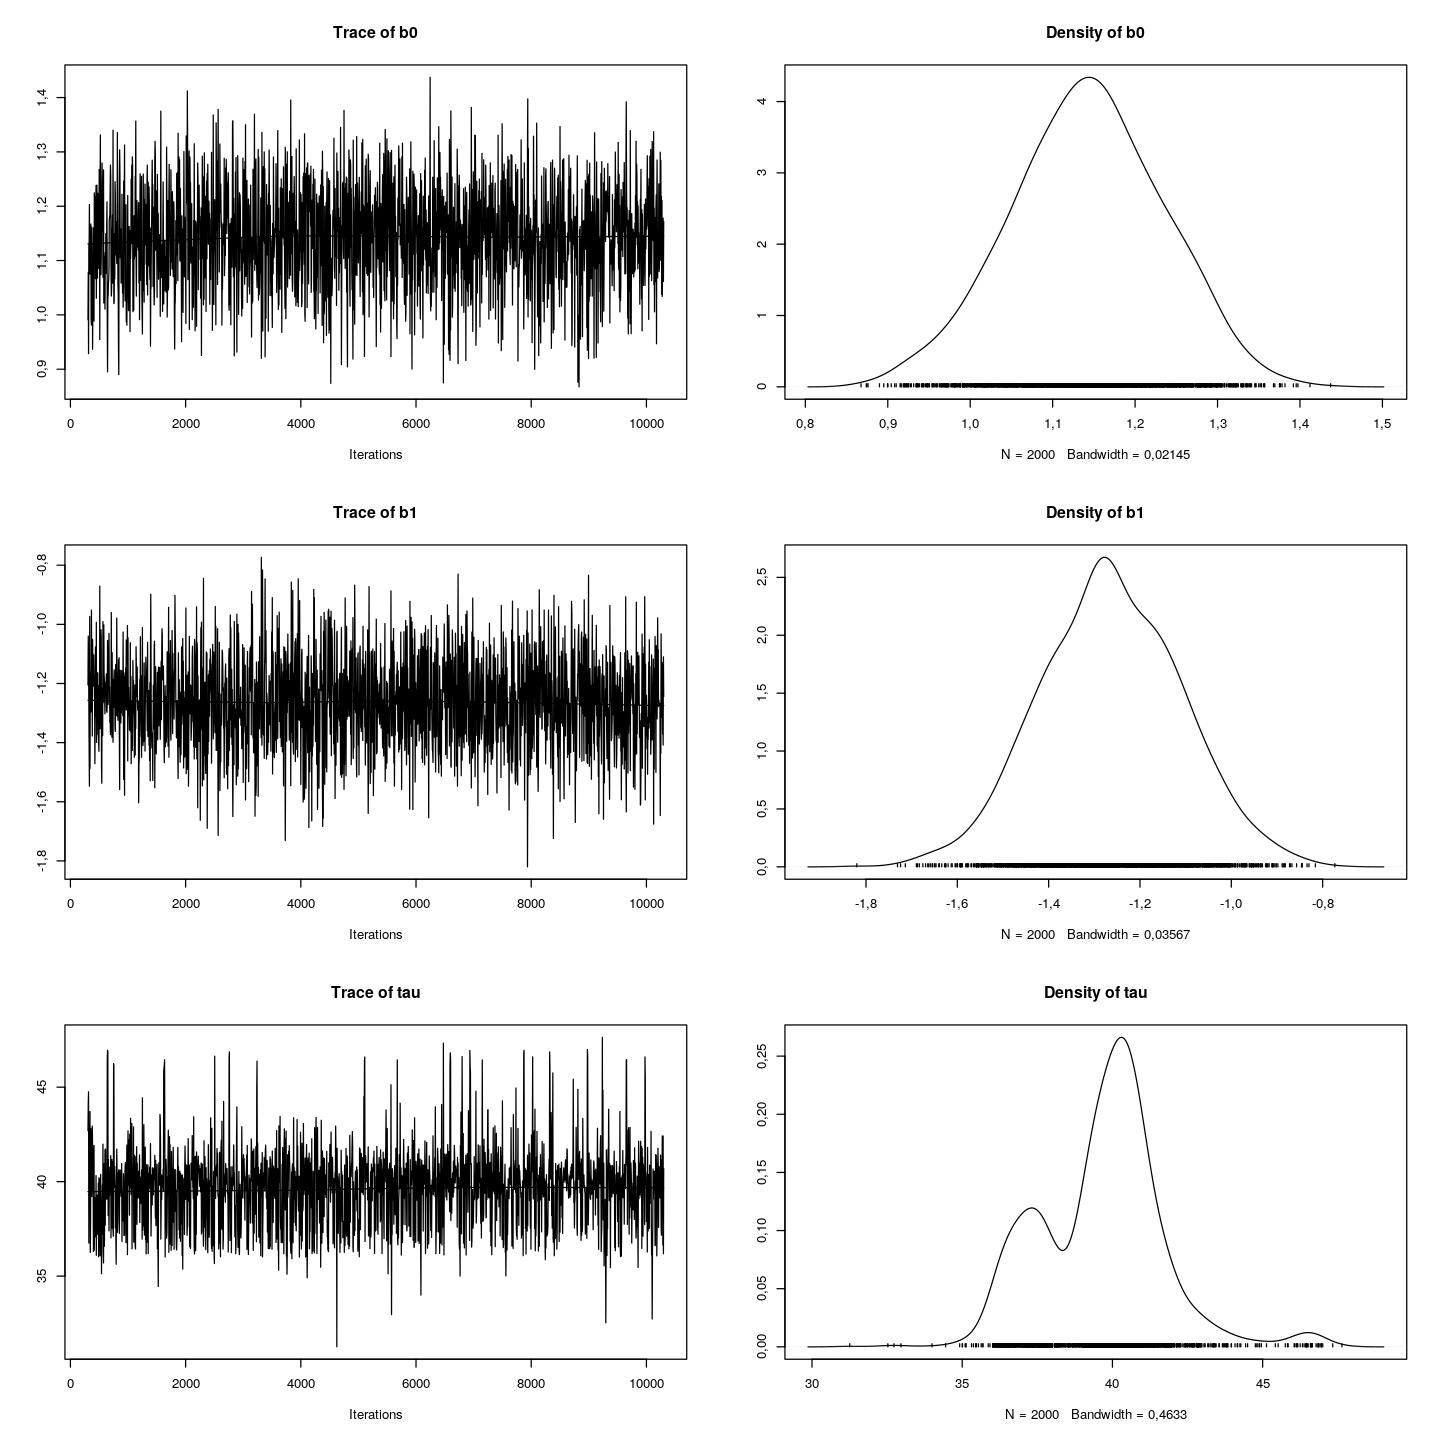

In [16]:
model<-textConnection(modelString)
jm <- jags.model(model, data, start_val, n.adapt = 300)
chain <- coda.samples(jm, c("tau", "b0", "b1"), n.iter=10000, thin = 5)
options(repr.plot.width=12,repr.plot.height=12)
plot(chain)

summ <- summary(chain) #to extract the params
param_val <- as.numeric(summ$statistics[,"Mean"]) #mean value of the parameters
param_low <- as.numeric(summ$quantiles[,1])#2.5%  quantile, lower buond of 95% cred int
param_hig <- as.numeric(summ$quantiles[,5])#97.5% quantile, upper buond of 95% cred int

print(paste("Parameter: b0   Mean: ", round(param_val[1], 2), " 95% Credibility interval: [", round(param_low[1],2), ",", round(param_hig[1],2),"]"))
print(paste("Parameter: b1   Mean: ", round(param_val[2], 2), "95% Credibility interval: [", round(param_low[2],2), ",", round(param_hig[2],2),"]"))
print(paste("Parameter: \u03c4    Mean: ", round(param_val[3], 3), "95% Credibility interval: [", round(param_low[3],2), ",", round(param_hig[3],2),"]"))



The sum of these results is shown in the following plots:

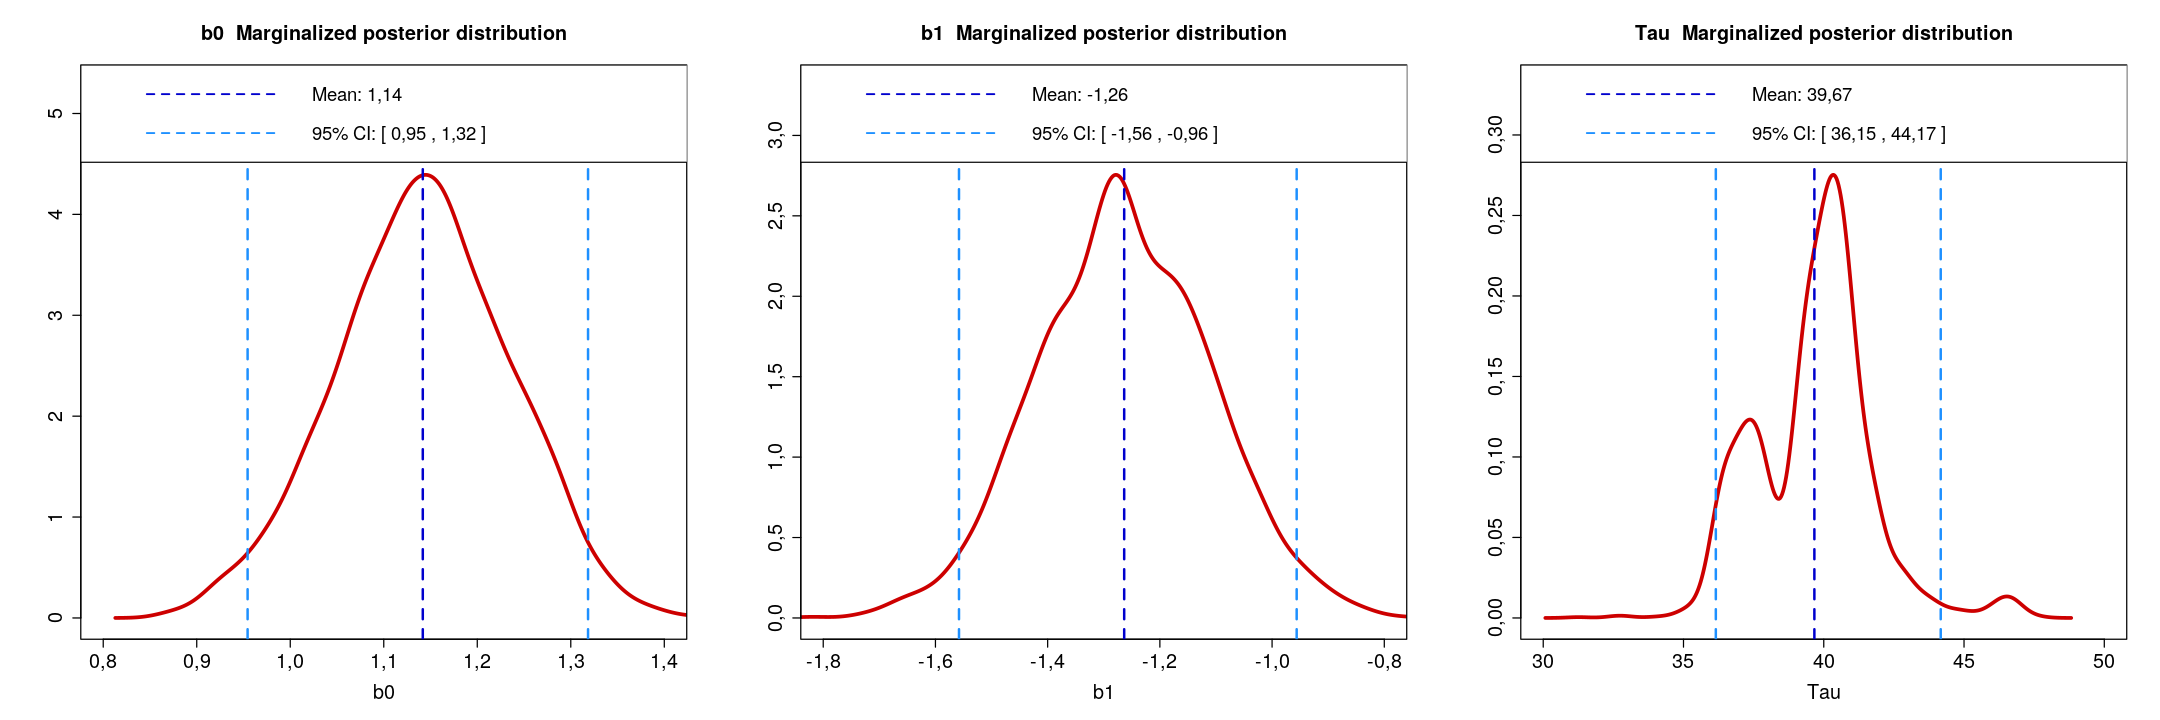

In [17]:
par(cex.lab=1.5, cex.axis=1.5, cex.main=1.5, mar=c(5, 5, 4, 2) + 0.1)
options(repr.plot.width=18,repr.plot.height=6)
area <- matrix (c(1,2,3), nrow=1, ncol=3, byrow=TRUE)
layout(area)

limits <- matrix(c(0.8,1.4,-1.8,-0.8, 30, 50),  nrow=3, ncol=2, byrow=TRUE); names <- c("b0", "b1", "Tau"); 
chain_df <- as.data.frame( as.mcmc(chain))
for (i in 1:3){
    dens <- density(chain_df[, i])
    plot(dens$x, dens$y, xlim=c(limits[i,1], limits[i,2]), 
         xlab=names[i], ylab="", main=paste(names[i], " Marginalized posterior distribution"),
         type='l', col='red3', lwd=3 , ylim=c(0, max(dens$y)*1.2)  )
    abline(v=param_val[i], col='blue3', lwd=2, lty='dashed' )
    abline(v=param_low[i], col='dodgerblue1', lwd=2, lty='dashed' )
    abline(v=param_hig[i], col='dodgerblue1', lwd=2, lty='dashed' )
    legend("topleft", legend=c(paste("Mean:", round(param_val[i], 2)), 
                               paste("95% CI: [", round(param_low[i],2), ",", round(param_hig[i],2),"]")),
           col=c("blue3", "dodgerblue1"), lty="dashed",
           y.intersp=2, x.intersp = 0.5, seg.len=2, lwd=1.5, cex=1.4)
}
           


One last thing we can do is to see how well our parameter estimation represent the data, in particular we are interested to see if the data lies within the region defined by the credibility intervals. In order to do this we first have to compute the mean value and credibility interval also of the sum of the $b_0$ and $b_1$ parameter, this is done numerically by adding the samples of the two parameters and then computing the mean and quantiles of the distribution obtained.

In [18]:
#computing the b0+b1 interval and mean
param_val <- c(param_val,mean(chain_df[, 1]+chain_df[,2]))
param_low <- c(param_low, quantile(chain_df[, 1]+chain_df[,2], 0.025))
param_hig <- c(param_hig, quantile(chain_df[, 1]+chain_df[,2], 0.975))

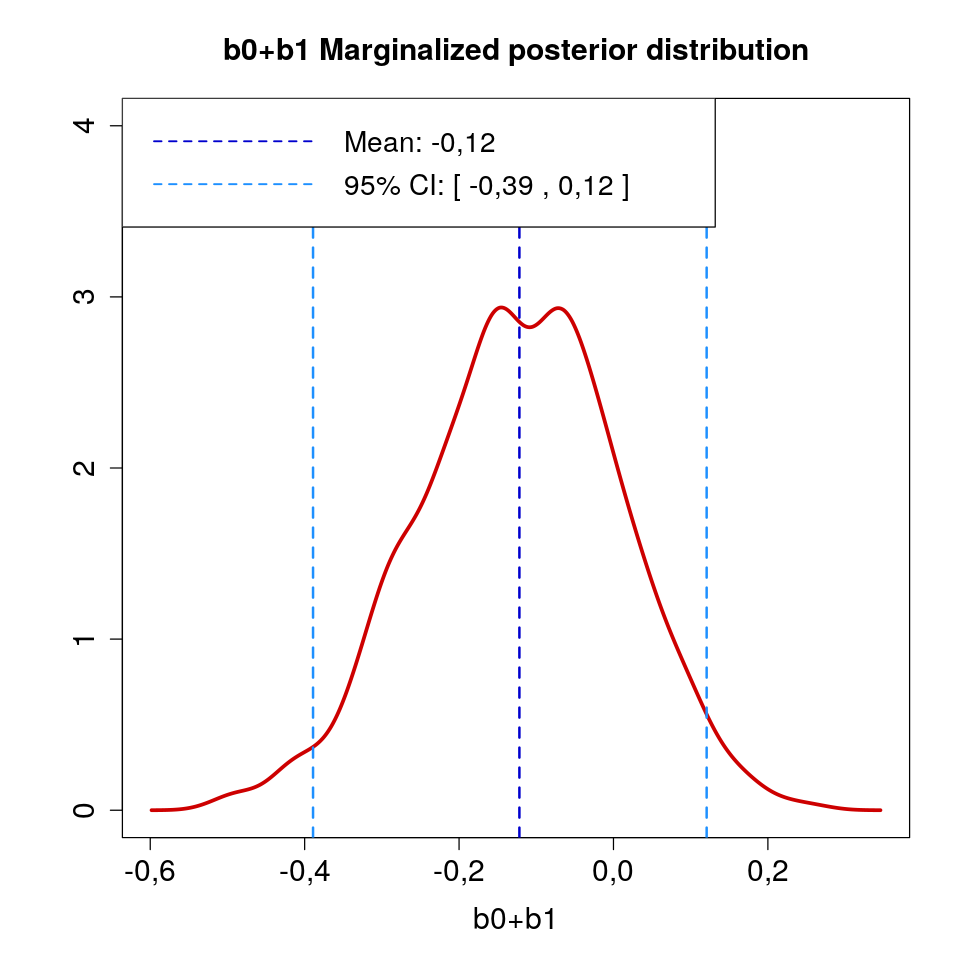

In [19]:
par(cex.lab=1.5, cex.axis=1.5, cex.main=1.5, mar=c(5, 5, 4, 2) + 0.1)
options(repr.plot.width=8,repr.plot.height=8)

#plotting the b0+b1 posterior
dens <- density(chain_df[, 1]+chain_df[,2])
plot(dens$x, dens$y,  xlab="b0+b1", ylab="", main=paste("b0+b1 Marginalized posterior distribution"),
         type='l', col='red3', lwd=3 , ylim=c(0,4 ))
    abline(v=param_val[4], col='blue3', lwd=2, lty='dashed' )
    abline(v=param_low[4], col='dodgerblue1', lwd=2, lty='dashed' )
    abline(v=param_hig[4], col='dodgerblue1', lwd=2, lty='dashed' )
    legend("topleft", legend=c(paste("Mean:", round(param_val[4], 2)), 
                               paste("95% CI: [", round(param_low[4],2), ",", round(param_hig[4],2),"]")),
           col=c("blue3", "dodgerblue1"), lty="dashed",
           y.intersp=1, x.intersp = 1, seg.len=5, lwd=1.5, cex=1.4)


In the following plot are then represented the data alongside with their expected value and standard deviation, this is possible since we know that the number of disasters follows a Poisson ($y_t \sim Pois(ut)$) distribution whose expected value and variance are known:
$$\mathcal{P}_{\lambda}(n)=\frac{\lambda^{n}}{n !} e^{-\lambda}
\quad\implies\quad
\begin{cases}
E[X]=\lambda \\
Var[x]=\lambda
\end{cases}$$
In order to easily see if the prediction is correct in the following plot the data are grouped in size $n=2$ and their mean is displayed, this allows us to make the plot more readable and to reduce the statistical fluctuations; in particualr the plot shows how the data respect the different expected value before and after the estimated year of change.

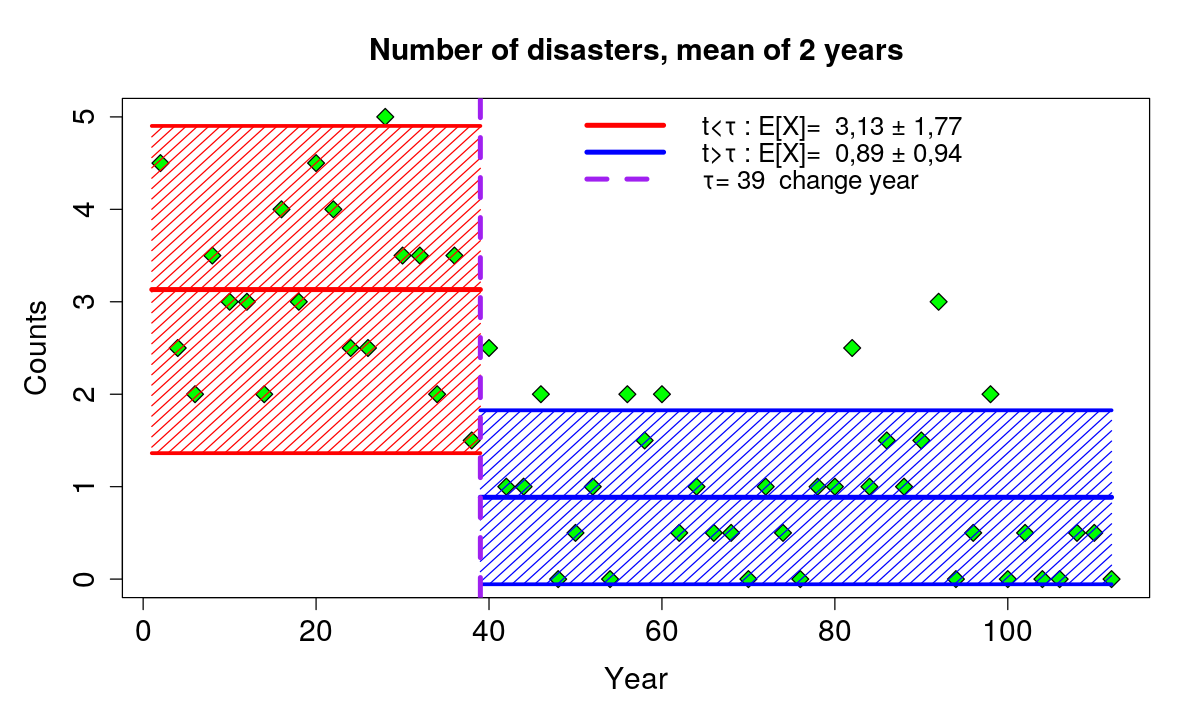

In [20]:
par(cex.lab=1.5, cex.axis=1.5, cex.main=1.5, mar=c(5, 5, 4, 2) + 0.1)
options(repr.plot.width=10,repr.plot.height=6)

n <- 2 #size of the groups for the mean
y_means= as.vector(tapply(data$D, rep(seq_along(data$D), each = n, length.out = length(data$D)), mean)) #mean by groups of n
xm <- seq(1,length(y_means),1)*n #x positions for the means
plot(xm, y_means, pch=23, cex=1.5, bg='green', xlab="Year", main=paste("Number of disasters, mean of", n, "years"), ylab="Counts") #data mediated plot

#plot of expected values
segments(1,   exp(param_val[1]) , as.integer(param_val[3]), exp(param_val[1]), col='red', lwd=4) 
segments(112, exp(param_val[4]) , as.integer(param_val[3]), exp(param_val[4]), col='blue', lwd=4)

#plot of the standard deviations
p1p <- exp(param_val[1])+sqrt(exp(param_val[1])); p1m <- exp(param_val[1])-sqrt(exp(param_val[1])); 
p4p <- exp(param_val[4])+sqrt(exp(param_val[4])); p4m <- exp(param_val[4])-sqrt(exp(param_val[4])); 
tau <- param_val[3]

#plot of the boxes around the expected values std, segment for lines and then polygon to fill
segments(1,   p1p , as.integer(tau), p1p, col='red' , lwd=3)
segments(1,   p1m , as.integer(tau), p1m, col='red' , lwd=3)
segments(112, p4p , as.integer(tau), p4p, col='blue', lwd=3) 
segments(112, p4m , as.integer(tau), p4m, col='blue', lwd=3)
polygon(c(1,1,as.integer(tau),as.integer(tau)), c(p1m, p1p, p1p, p1m),
        col='red', density=20, angle=60, border = NA )
polygon(c(112,112,as.integer(tau),as.integer(tau)), c(p4m, p4p, p4p, p4m),
        col='blue', density=20, angle=60, border = NA )
abline(v=as.integer(tau), col='purple', lwd=4, lty='dashed')
legend("topright", c(paste("t<\u03c4 : E[X]= ",round(exp(param_val[1]),2), "±" , round(sqrt(exp(param_val[1])),2)),
                     paste("t>\u03c4 : E[X]= ",round(exp(param_val[4]),2), "±" , round(sqrt(exp(param_val[4])),2)),
                     paste("\u03c4=", as.integer(param_val[3]), " change year")), 
       lty=c("solid", "solid", "dashed"), col=c("red", "blue", "purple"), cex=1.3, lwd=4, bty='n')


#if we want we can plot also the credibility interval, 
#they are tighter than the std, deviations but with n=4/5 the data are inside them (less fluctiuations)
#segments(1,   exp(param_low[1]) , as.integer(tau), exp(param_low[1]))
#segments(1,   exp(param_hig[1]) , as.integer(tau), exp(param_hig[1]))
#segments(112, exp(param_low[4]) , as.integer(tau), exp(param_low[4]))
#segments(112, exp(param_hig[4]) , as.integer(tau), exp(param_hig[4]))
